In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

In [2]:
device = 'cuda'

In [3]:
# Loading the Navier-Stokes dataset in 128x128 resolution
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

torch.Size([1000, 1, 16, 16])
torch.Size([1000, 1, 16, 16])
UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


/tmp/ipykernel_24478/1620983364.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


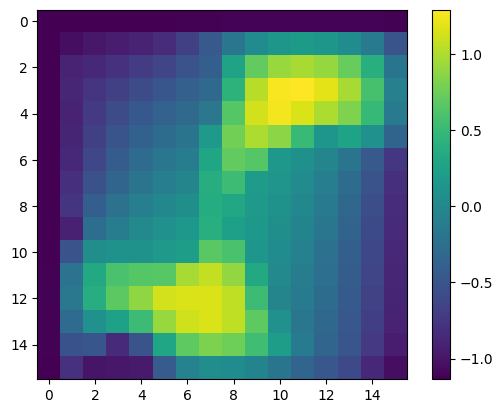

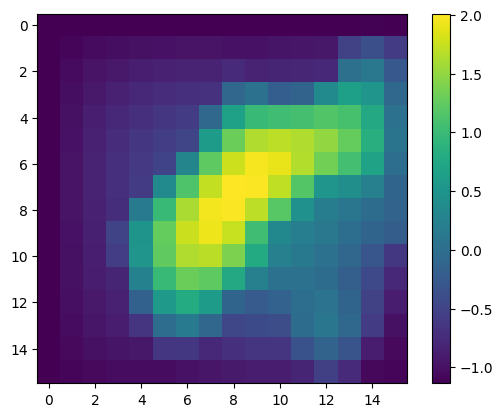

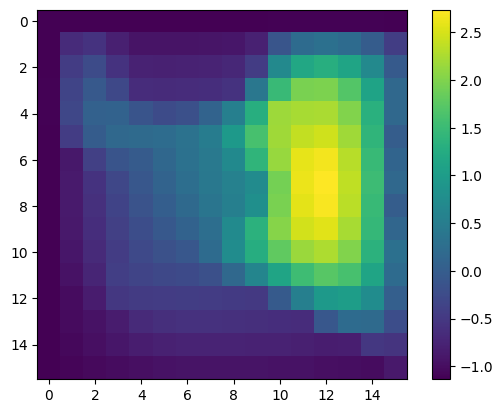

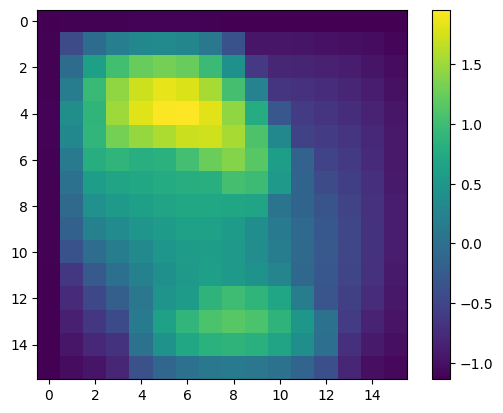

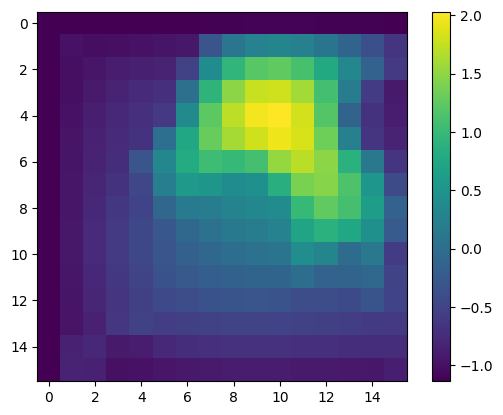

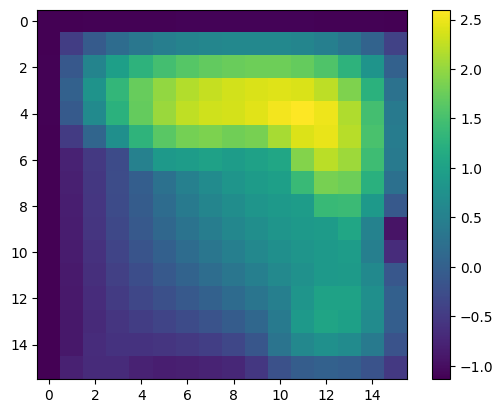

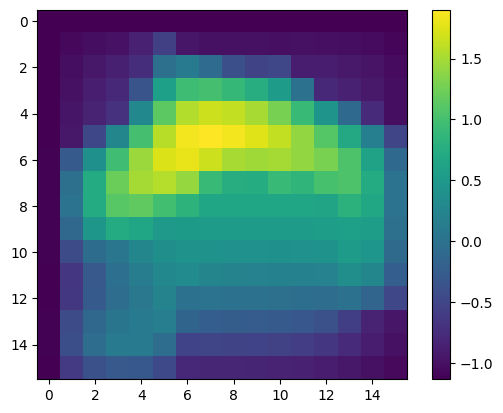

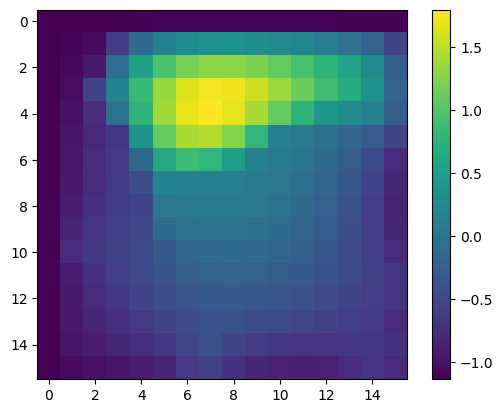

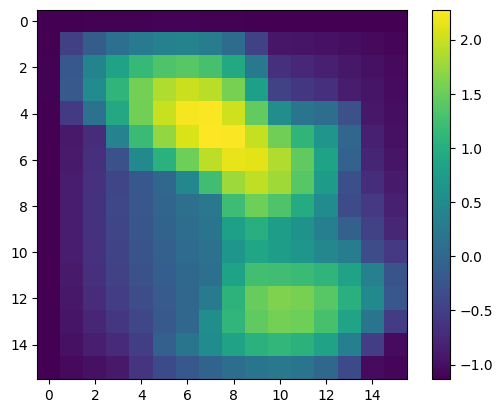

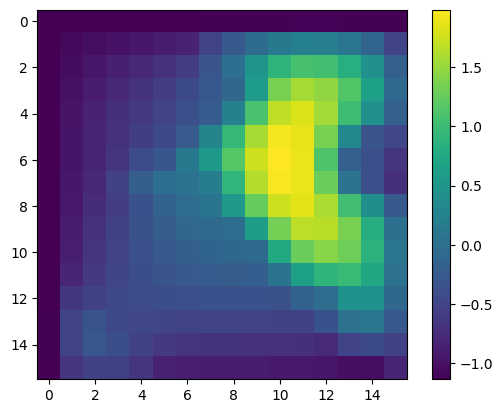

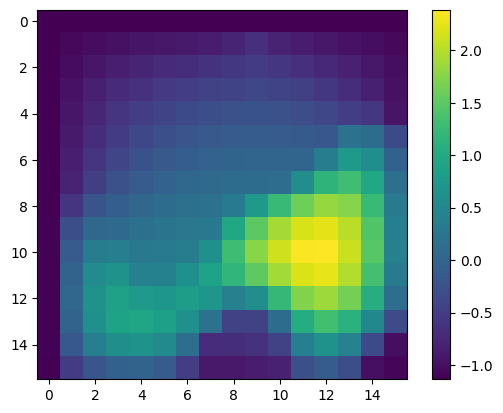

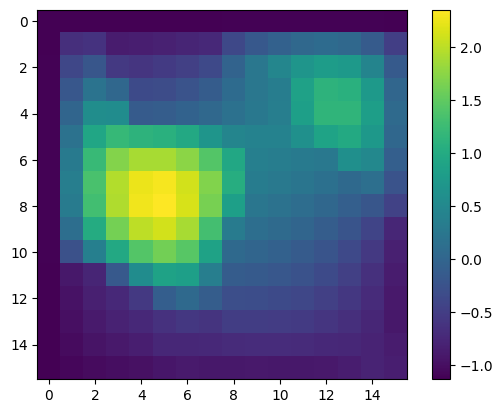

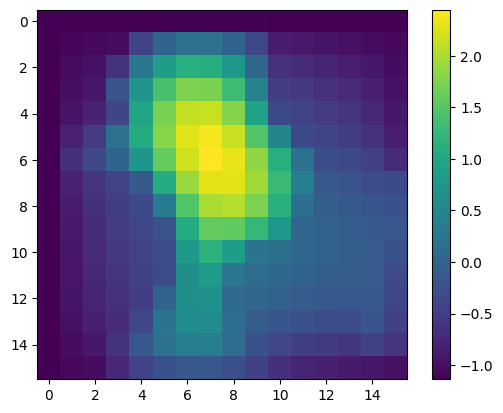

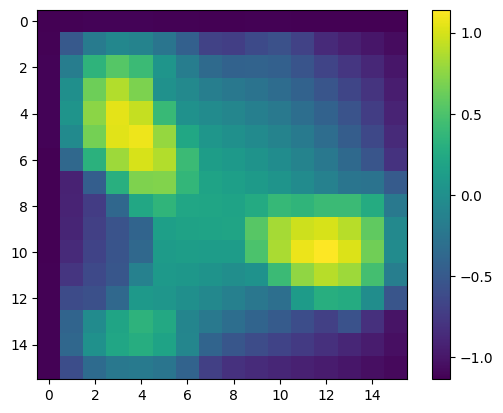

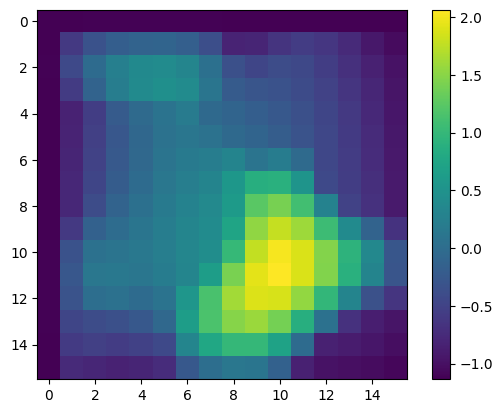

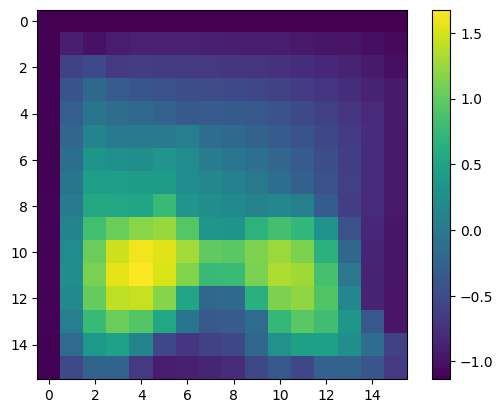

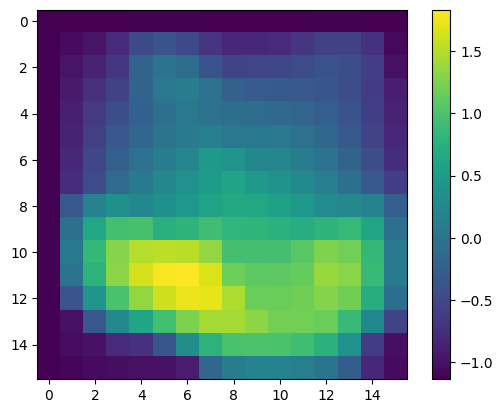

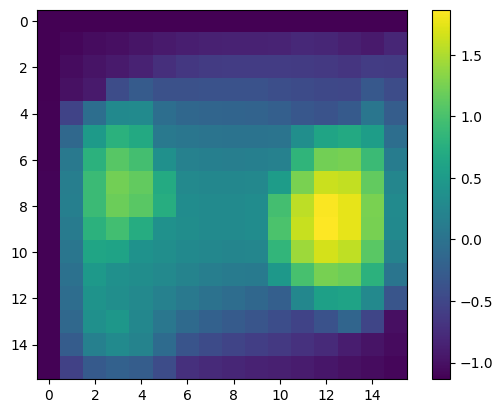

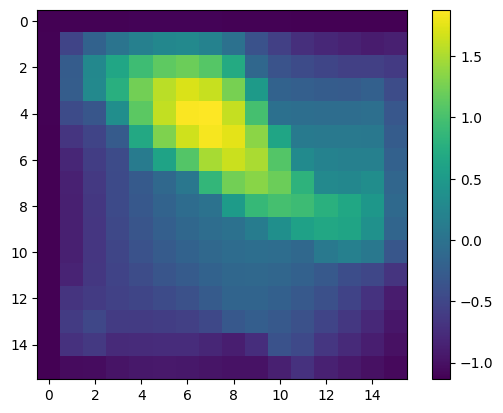

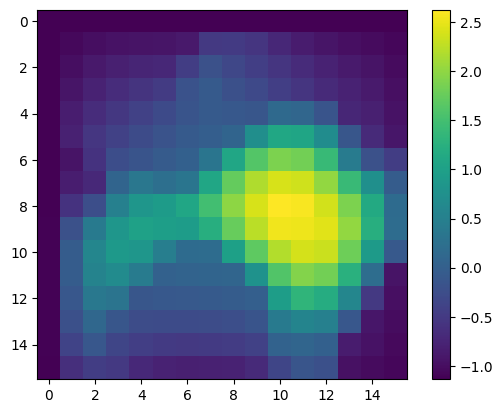

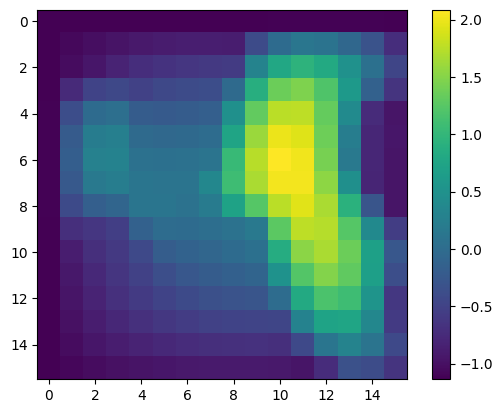

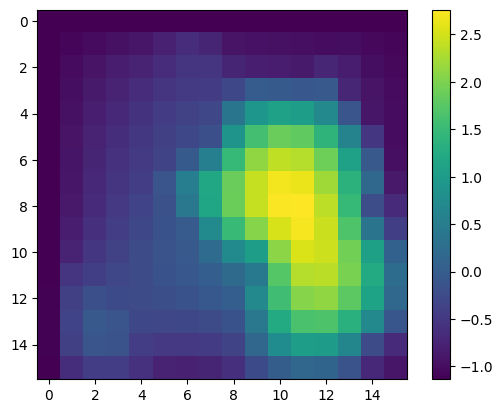

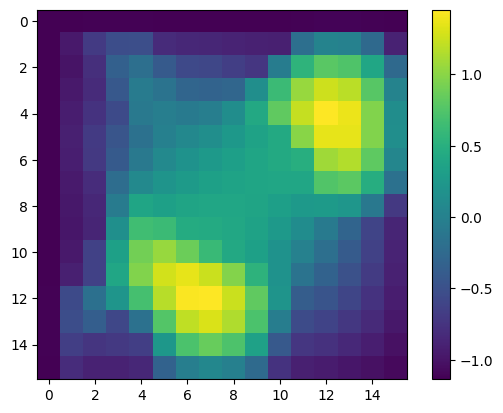

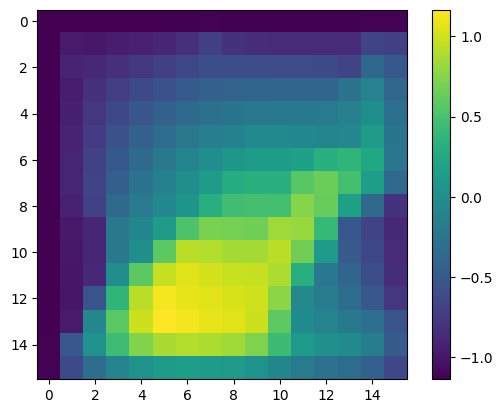

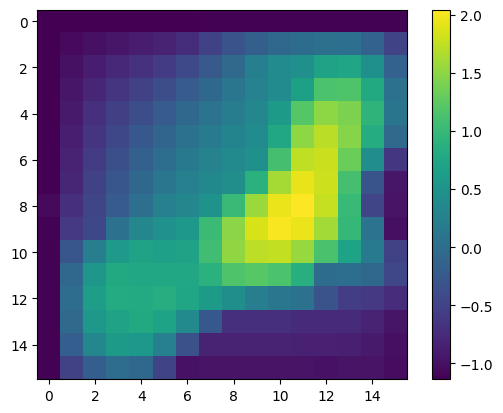

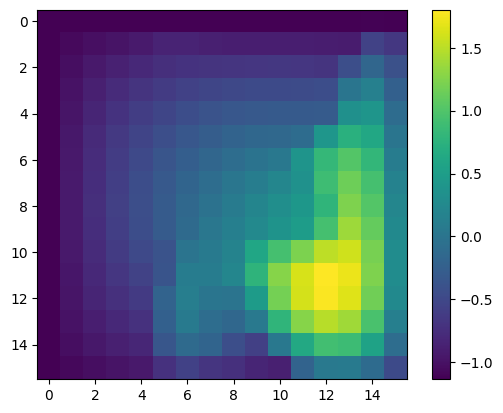

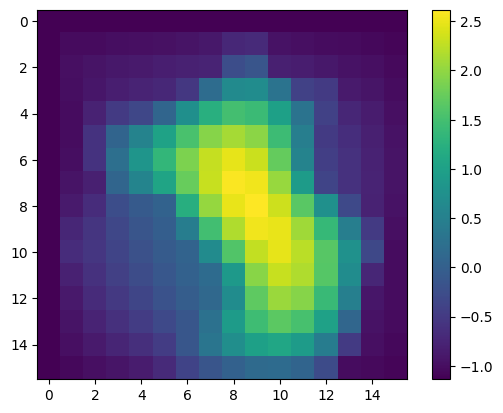

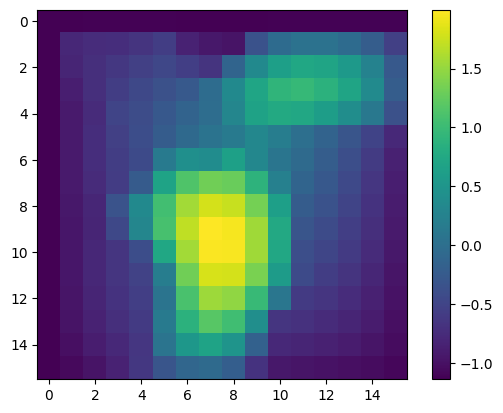

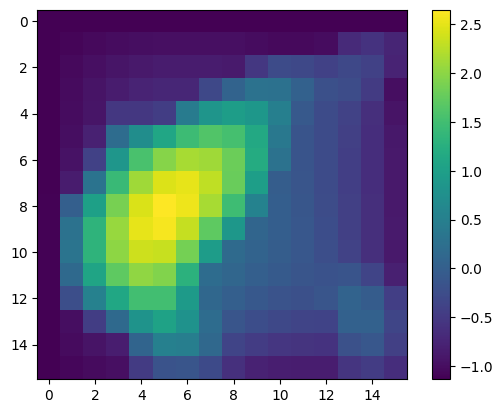

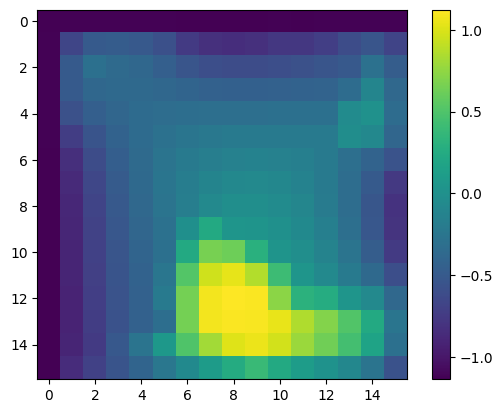

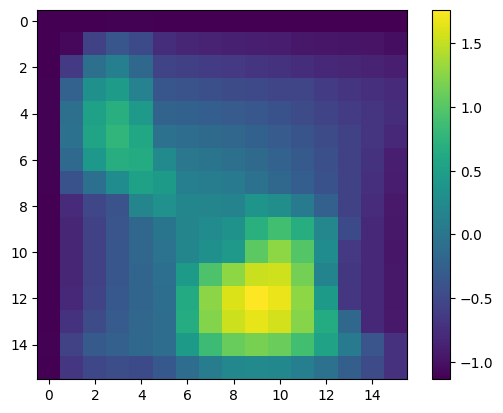

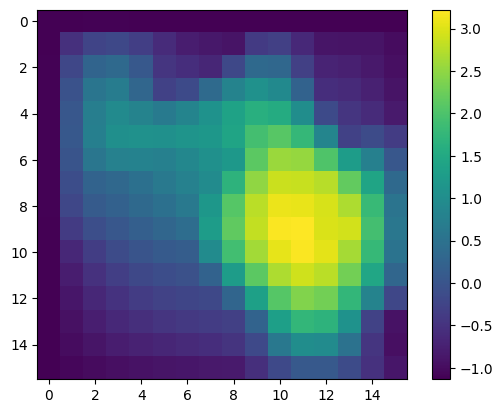

In [20]:
for i, batched_id_sample in enumerate(train_loader):
#     plt.figure()
#     plt.imshow(batched_id_sample['x'][1,2])
    plt.figure()
    plt.imshow(batched_id_sample['y'][1,0])
    plt.colorbar()

In [14]:
# We create a tensorized FNO model

model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=1)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()
print('\n### MODEL ###\n', model)


Our model has 3857 parameters.

### MODEL ###
 TFNO(
  (convs): FactorizedSpectralConv(
    (weight): ModuleList(
      (0): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (1): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (2): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (3): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (4): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (5): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (6): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
      (7): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(1, 1, 1, 1))
    )
  )
  (fno_skips): ModuleList(
    (0): SoftGating()
    (1): SoftGating()
    (2): SoftGating()
    (3): SoftGating()
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (f

/home/sci/hdai/anaconda2/envs/fno/lib/python3.10/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 4. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [15]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)


### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###


In [16]:
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [17]:
# Create the trainer
trainer = Trainer(model, n_epochs=20,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


In [18]:
# Actually train the model on our small Darcy-Flow dataset

trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
[0] time=0.72, avg_loss=35.8985, train_err=0.7180, 16_h1=0.5570, 16_l2=0.4078, 32_h1=0.6527, 32_l2=0.4079
[3] time=0.67, avg_loss=15.3907, train_err=0.3078, 16_h1=0.3286, 16_l2=0.2595, 32_h1=0.3858, 32_l2=0.2566
[6] time=0.61, avg_loss=12.1799, train_err=0.2436, 16_h1=0.2702, 16_l2=0.2054, 32_h1=0.3507, 32_l2=0.2157
[9] time=0.59, avg_loss=11.5430, train_err=0.2309, 16_h1=0.2331, 16_l2=0.1724, 32_h1=0.3138, 32_l2=0.1705
[12] time=0.61, avg_loss=10.9678, train_err=0.2194, 16_h1=0.2204, 16_l2=0.1639, 32_h1=0.3212, 32_l2=0.1849
[15] time=0.60, avg_loss=10.6677, train_err=0.2134, 16_h1=0.2159, 16_l2=0.1588, 32_h1=0.3212, 32_l2=0.1781
[18] time=0.60, avg_loss=10.3932, train_err=0.2079, 16_h1=0.2106, 16_l2=0.1550, 32_h1=0.3022, 32_l2=0.1673


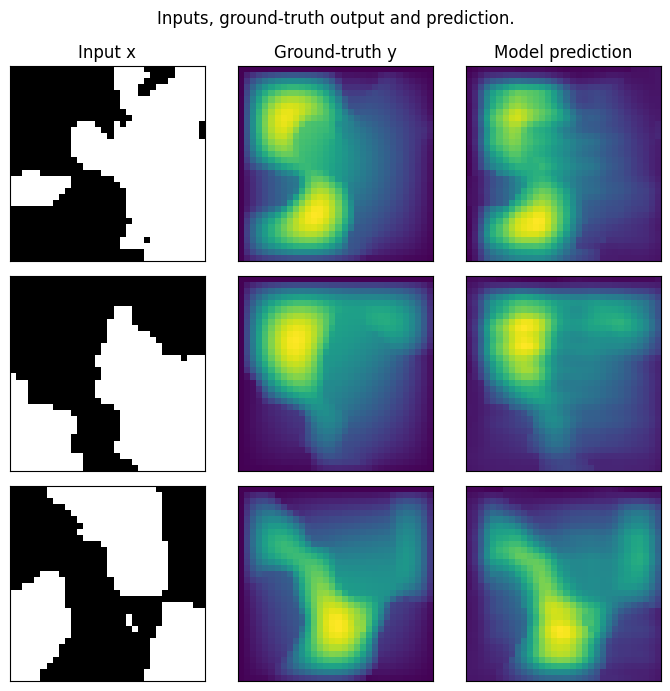

In [19]:
# Plot the prediction, and compare with the ground-truth 
# Note that we trained on a very small resolution for
# a very small number of epochs
# In practice, we would train at larger resolution, on many more samples.
# 
# However, for practicity, we created a minimal example that
# i) fits in just a few Mb of memory
# ii) can be trained quickly on CPU
#
# In practice we would train a Neural Operator on one or multiple GPUs

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x'].to(device)
    # Ground-truth
    y = data['y'].to(device)
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].to('cpu'), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.to('cpu').squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.to('cpu').squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
# fig.show()

In [10]:
x.shape

torch.Size([3, 32, 32])